In [1]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump

import warnings
warnings.filterwarnings("ignore")

## Training prottrans_t5_uniref

In [2]:
df_data = pd.read_csv("../../selected_strategies/dna_binding/prottrans_t5_uniref.csv")

df_positive = df_data[df_data["dna_interaction"] == 1]
df_negative = df_data[df_data["dna_interaction"] == 0]

df_data_negative_shuffle = shuffle(df_negative, random_state=42)
df_data_negative_to_train = df_data_negative_shuffle[:len(df_positive)]

df_to_train = pd.concat([df_positive, df_data_negative_to_train], axis=0)

response = df_to_train["dna_interaction"]
df_to_train = df_to_train.drop(columns=["dna_interaction"])

X_train, X_test, y_train, y_test = train_test_split(df_to_train, response, random_state=42, test_size=0.3)

### Training models with ExtraTreesClassifier

In [3]:
extra_tree_model = ExtraTreesClassifier(
    n_estimators=2182,
    criterion='log_loss',
    min_samples_split=3,
    min_samples_leaf=1, 
    max_features='sqrt'
)

extra_tree_model.fit(X=X_train, y=y_train)
y_pred = extra_tree_model.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["ExtraTreesClassifier", "prottrans_t5_uniref", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df1 = pd.DataFrame(columns=columns, data= row)
print(df1)

name_export = "../../trained_models/dna_binding/ExtraTreesClassifier_prottrans_t5_uniref.joblib"
dump(extra_tree_model, name_export)

              Algorithm              Encoder  test_accuracy  test_precision  \
0  ExtraTreesClassifier  prottrans_t5_uniref       0.943546        0.942897   

    test_f1  test_recall  test_mcc                     test_cm  
0  0.954742     0.931342  0.887362  [[5878, 272], [423, 5738]]  


['../../trained_models/dna_binding/ExtraTreesClassifier_prottrans_t5_uniref.joblib']

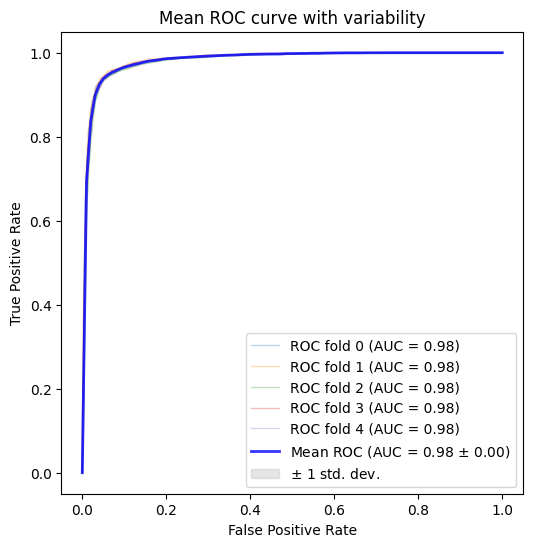

In [4]:
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(figsize=(6, 6))

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    extra_tree_model.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        extra_tree_model,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.savefig("../../results_optimization/dna_binding/ExtraTreesClassifier_prottrans_t5_uniref.svg")

### Training with Gradient Boosting

In [18]:
gradient_model = GradientBoostingClassifier(
    loss='log_loss',
    learning_rate=0.02020249526430644,
    n_estimators=2822,
    criterion='friedman_mse',
    min_samples_split=26, 
    min_samples_leaf=8,
    max_depth=6,
    max_features='sqrt',
    n_iter_no_change=9
)

gradient_model.fit(X=X_train, y=y_train)
y_pred = gradient_model.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["GradientBoostingClassifier", "prottrans_t5_uniref", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df2 = pd.DataFrame(columns=columns, data= row)
print(df2)

name_export = "../../trained_models/dna_binding/GradientBoostingClassifier_prottrans_t5_uniref.joblib"
dump(gradient_model, name_export)

                    Algorithm              Encoder  test_accuracy  \
0  GradientBoostingClassifier  prottrans_t5_uniref       0.942572   

   test_precision   test_f1  test_recall  test_mcc                     test_cm  
0        0.942262  0.948225     0.936374  0.885214  [[5835, 315], [392, 5769]]  


['../../trained_models/dna_binding/GradientBoostingClassifier_prottrans_t5_uniref.joblib']

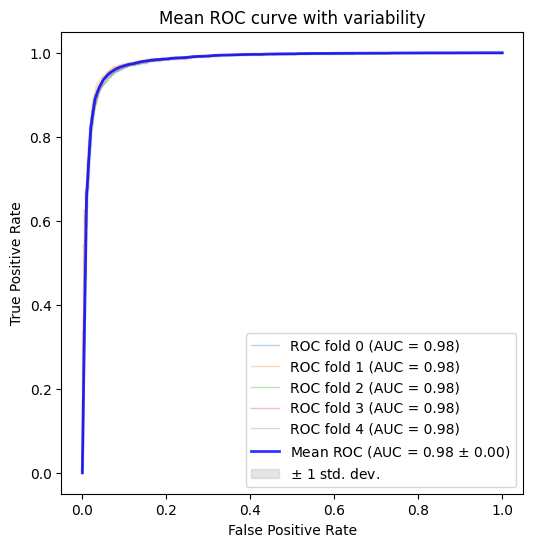

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    gradient_model.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        gradient_model,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.savefig("../../results_optimization/dna_binding/GradientBoostingClassifier_prottrans_t5_uniref.svg")

### Training with KNN

In [14]:
knn_model = KNeighborsClassifier(
    n_neighbors=3,
    leaf_size=24,
    algorithm='ball_tree',
    metric='minkowski'
)

knn_model.fit(X=X_train, y=y_train)
y_pred = knn_model.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["KNeighborsClassifier", "prottrans_t5_uniref", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df3 = pd.DataFrame(columns=columns, data= row)
print(df3)

name_export = "../../trained_models/dna_binding/KNeighborsClassifier_prottrans_t5_uniref.joblib"
dump(knn_model, name_export)

              Algorithm              Encoder  test_accuracy  test_precision  \
0  KNeighborsClassifier  prottrans_t5_uniref       0.933149        0.934155   

    test_f1  test_recall  test_mcc                     test_cm  
0  0.921111     0.947573  0.866653  [[5650, 500], [323, 5838]]  


['../../trained_models/dna_binding/KNeighborsClassifier_prottrans_t5_uniref.joblib']

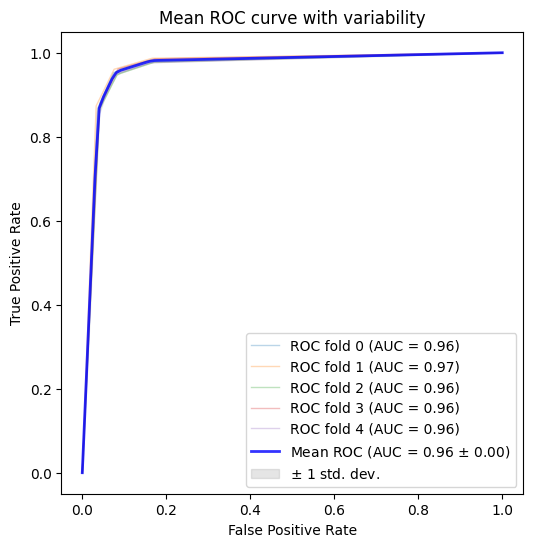

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    knn_model.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        knn_model,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.savefig("../../results_optimization/dna_binding/KNeighborsClassifier_prottrans_t5_uniref.svg")

### Training Random Forest

In [15]:
rf_model = RandomForestClassifier(
    n_estimators=327,
    criterion='gini',
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2'
)

rf_model.fit(X=X_train, y=y_train)
y_pred = rf_model.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["RandomForestClassifier", "prottrans_t5_uniref", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df4 = pd.DataFrame(columns=columns, data= row)
print(df4)

name_export = "../../trained_models/dna_binding/RandomForestClassifier_prottrans_t5_uniref.joblib"
dump(rf_model, name_export)

                Algorithm              Encoder  test_accuracy  test_precision  \
0  RandomForestClassifier  prottrans_t5_uniref        0.93323        0.932201   

    test_f1  test_recall  test_mcc                     test_cm  
0  0.947677     0.917221  0.866913  [[5838, 312], [510, 5651]]  


['../../trained_models/dna_binding/RandomForestClassifier_prottrans_t5_uniref.joblib']

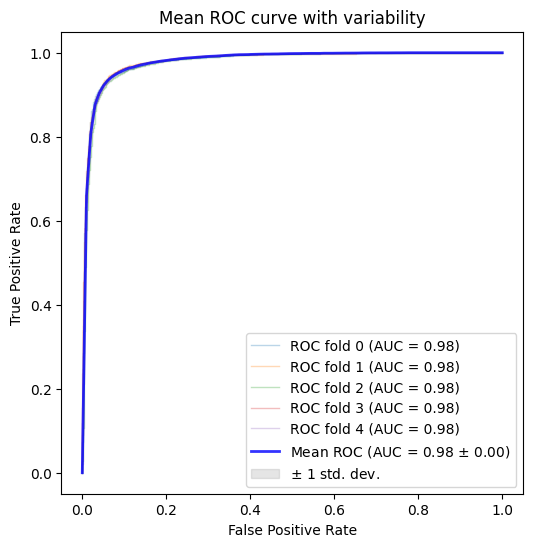

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    rf_model.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        rf_model,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.savefig("../../results_optimization/dna_binding/RandomForestClassifier_prottrans_t5_uniref.svg")

### Training ExtraTrees with prottrans t5bdf

In [11]:
df_data = pd.read_csv("../../selected_strategies/dna_binding/prottrans_t5bdf.csv")

df_positive = df_data[df_data["dna_interaction"] == 1]
df_negative = df_data[df_data["dna_interaction"] == 0]

df_data_negative_shuffle = shuffle(df_negative, random_state=42)
df_data_negative_to_train = df_data_negative_shuffle[:len(df_positive)]

df_to_train = pd.concat([df_positive, df_data_negative_to_train], axis=0)

response = df_to_train["dna_interaction"]
df_to_train = df_to_train.drop(columns=["dna_interaction"])

X_train, X_test, y_train, y_test = train_test_split(df_to_train, response, random_state=42, test_size=0.3)

In [16]:
extra_tree_model_2 = ExtraTreesClassifier(
    n_estimators=3071, 
    criterion='entropy',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt'
)

extra_tree_model_2.fit(X=X_train, y=y_train)
y_pred = extra_tree_model_2.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["ExtraTreesClassifier", "prottrans_t5bdf", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df5 = pd.DataFrame(columns=columns, data= row)
print(df5)

name_export = "../../trained_models/dna_binding/ExtraTreesClassifier_prottrans_t5bdf.joblib"
dump(extra_tree_model_2, name_export)

              Algorithm          Encoder  test_accuracy  test_precision  \
0  ExtraTreesClassifier  prottrans_t5bdf       0.940054        0.939059   

    test_f1  test_recall  test_mcc                     test_cm  
0  0.955791     0.922902  0.880633  [[5887, 263], [475, 5686]]  


['../../trained_models/dna_binding/ExtraTreesClassifier_prottrans_t5bdf.joblib']

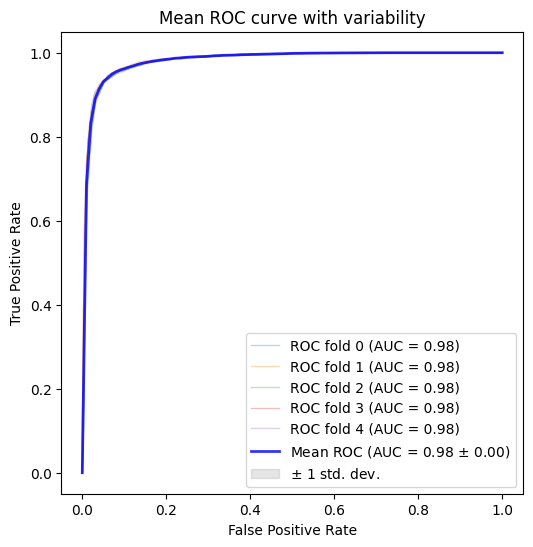

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    extra_tree_model_2.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        extra_tree_model_2,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.savefig("../../results_optimization/dna_binding/ExtraTreesClassifier_prottrans_t5bdf.svg")

In [19]:
df_full = pd.concat([df1, df2, df3, df4, df5], axis=0)
df_full

,Algorithm,Encoder,test_accuracy,test_precision,test_f1,test_recall,test_mcc,test_cm
0,ExtraTreesClassifier,prottrans_t5_uniref,0.943546,0.942897,0.954742,0.931342,0.887362,"[[5878, 272], [423, 5738]]"
0,GradientBoostingClassifier,prottrans_t5_uniref,0.942572,0.942262,0.948225,0.936374,0.885214,"[[5835, 315], [392, 5769]]"
0,KNeighborsClassifier,prottrans_t5_uniref,0.933149,0.934155,0.921111,0.947573,0.866653,"[[5650, 500], [323, 5838]]"
0,RandomForestClassifier,prottrans_t5_uniref,0.933230,0.932201,0.947677,0.917221,0.866913,"[[5838, 312], [510, 5651]]"
0,ExtraTreesClassifier,prottrans_t5bdf,0.940054,0.939059,0.955791,0.922902,0.880633,"[[5887, 263], [475, 5686]]"
